In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# # 필요한 라이브러리

In [ ]:
from IPython.display import Image

import matplotlib.pyplot as plt

 # # 데이터 획득

## ## num_words
  * 훈련 데이터에서 가장 자주 나타나는 단어 n 개만 사용하겠다는 의미
  * num_words = 10000
    - 자주 나타나는 만 개만 사용하고 드물게 나타나는 단어는 무시하겠다는 의미

In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
train_data, train_labels

(array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
        list([1, 194, 1153, 194, 8255, 78, 22

# # 데이터 준비

## ## 리스트를 텐서로 바꾸는 두 가지 방법
  * 신경망에 숫자 리스트를 주입할 수는 없습니다.
    - 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환합니다. 그다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용합니다(Embedding 층을 말하며 나중에 자세히 다루겠습니다).
    - 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환합니다. 예를 들면 시퀀스 [3, 5]를 인덱스 3과 5의 위치는 1이고 그 외는 모두 0인 10,000차원의 벡터로 각각 변환합니다. 그다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫 번째 층으로 사용합니다.
    - 여기서는 두 번째 방식을 사용하고 이해를 돕기 위해 직접 데이터를 원-핫 벡터로 만들겠습니다:

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
    return results

# 훈련 데이터를 벡터로 변환합니다
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환합니다
x_test = vectorize_sequences(test_data)

In [ ]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

## ## 레이블을 벡터로 변환

### ### 벡터란?
  * 숫자의 배열
  * 1D 텐서

In [ ]:
x = np.array([12,3,6,14,7])
x

array([12,  3,  6, 14,  7])

In [ ]:
x.ndim

1

In [ ]:
# 레이블을 벡터로 바꿉니다
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# # 신경망 만들기
  * 입력 데이터가 벡터이고 레이블은 스칼라(1 또는 0)입니다.
  * 16개의 은닉 유닛을 가진 두 개의 은닉층
    - 16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻
    - 입력 데이터와 W를 점곱하면 입력 데이터가 16 차원으로 표현된 공간으로 투영
  * 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층
    - Dense(units=1)

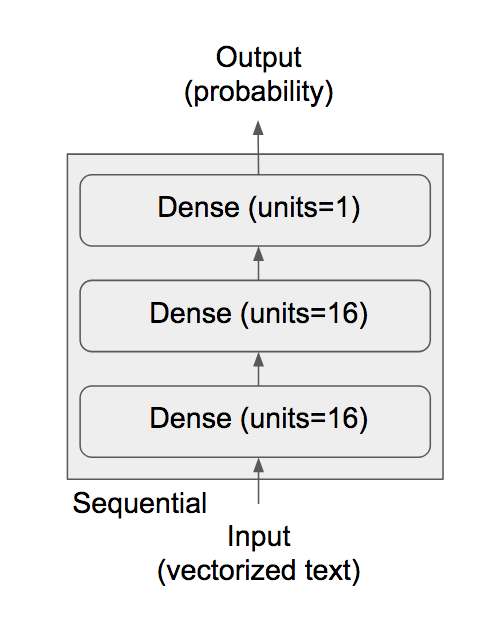

In [ ]:
#영화리뷰이진분류_신경망.png
Image('/content/drive/MyDrive/Colab Notebooks/딥러닝/프랑소와 숄레 - 케라스 창시자에게 배우는 딥러닝/res/영화리뷰이진분류_신경망.png')

## ## 시그모이드 vs. relu
  * 중간에 있는 은닉층은 활성화 함수로 relu를 사용하고 마지막 층은 확률(0과 1 사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미합니다)을 출력하기 위해 시그모이드 활성화 함수를 사용합니다.
  * relu는 음수를 0으로 만드는 함수입니다. 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있습니다.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## ## 손실 함수, 옵티마이저
  * 이진 분류 문제이고 신경망의 출력이 확률이기 때문에(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았습니다), 
    - binary_crossentropy 손실이 적합합니다. 
    - 이 함수가 유일한 선택은 아니고 예를 들어 mean_squared_error를 사용할 수도 있습니다. 
    - 확률을 출력하는 모델을 사용할 때는 크로스엔트로피가 최선의 선택입니다. 
    - 크로스엔트로피는 정보 이론 분야에서 온 개념으로 확률 분포 간의 차이를 측정합니다. 여기에서는 원본 분포와 예측 분포 사이를 측정합니다.
  * rmsprop 옵티마이저

### ### 참고
  * 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실 함수, 측정 지표를 문자열로 지정하는 것이 가능합니다. 이따금 옵티마이저의 매개변수를 바꾸거나 자신만의 손실 함수, 측정 함수를 전달해야 할 경우가 있습니다. 전자의 경우에는 옵티마이저 파이썬 클래스를 사용해 객체를 직접 만들어 optimizer 매개변수에 전달하면 됩니다:

#### #### 전자

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### #### 후자

In [ ]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# # 훈련 / 검증

## ## 훈련 데이터 만들기
  * 훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 떼어서 검증 세트를 만들어야 합니다:

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## ## 훈련
  * 이제 모델을 512개 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킵니다(x_train과 y_train 텐서에 있는 모든 샘플에 대해 20번 반복합니다). 동시에 따로 떼어 놓은 10,000개의 샘플에서 손실과 정확도를 측정할 것입니다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 합니다:

## ## 평가 용어
  * 매 에포크 마다의 훈련 손실값 (loss)
  * 매 에포크 마다의 훈련 정확도 (acc)
  * 매 에포크 마다의 검증 손실값 (val_loss)
  * 매 에포크 마다의 검증 정확도 (val_acc)

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 5s 91ms/step - loss: 0.5170 - accuracy: 0.7815 - val_loss: 0.3877 - val_accuracy: 0.8706
Epoch 2/20
30/30 [==============================] - 1s 45ms/step - loss: 0.3045 - accuracy: 0.9038 - val_loss: 0.3044 - val_accuracy: 0.8864
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 0.2173 - accuracy: 0.9307 - val_loss: 0.2879 - val_accuracy: 0.8847
Epoch 4/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1725 - accuracy: 0.9425 - val_loss: 0.2967 - val_accuracy: 0.8822
Epoch 5/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1357 - accuracy: 0.9591 - val_loss: 0.2833 - val_accuracy: 0.8862
Epoch 6/20
30/30 [==============================] - 1s 44ms/step - loss: 0.1109 - accuracy: 0.9669 - val_loss: 0.2922 - val_accuracy: 0.8863
Epoch 7/20
30/30 [==============================] - 1s 44ms/step - loss: 0.0881 - accuracy: 0.9752 - val_loss: 0.3412 - val_accuracy: 0.8778
Epoch 8/20
30

## ## 시각화
  * model.fit() 메서드는 History 객체를 반환합니다.
  * 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있습니다. 한 번 확인해 보죠:

In [ ]:
history

In [ ]:
history_dict = history.history
history_dict

{'accuracy': [0.7815333604812622,
  0.9038000106811523,
  0.9306666851043701,
  0.9425333142280579,
  0.9591333270072937,
  0.966866672039032,
  0.9751999974250793,
  0.980733335018158,
  0.9833333492279053,
  0.9905333518981934,
  0.9929333329200745,
  0.9950000047683716,
  0.9959333539009094,
  0.9976000189781189,
  0.9987333416938782,
  0.9984666705131531,
  0.9998666644096375,
  0.9987999796867371,
  0.9998666644096375,
  0.9984666705131531],
 'loss': [0.51702880859375,
  0.30450689792633057,
  0.2173367291688919,
  0.17245839536190033,
  0.13567925989627838,
  0.11087098717689514,
  0.0881117507815361,
  0.07241081446409225,
  0.06066489219665527,
  0.04540495201945305,
  0.03475215658545494,
  0.02725217305123806,
  0.02292846515774727,
  0.016443489119410515,
  0.012629503384232521,
  0.01110552717000246,
  0.005196064244955778,
  0.007245251443237066,
  0.002944067120552063,
  0.0064917560666799545],
 'val_accuracy': [0.8705999851226807,
  0.8863999843597412,
  0.88470000028610

In [ ]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### ### 손실

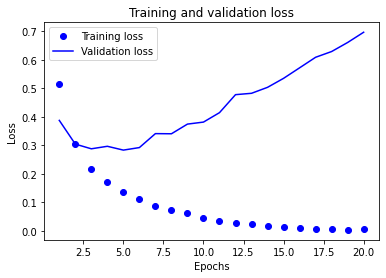

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')

# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

### ### 정확도

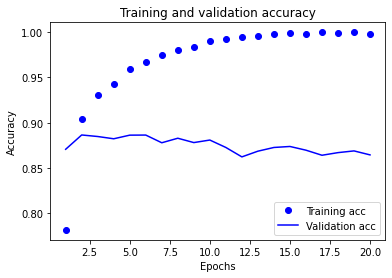

In [ ]:
plt.clf()   # 그래프를 초기화합니다
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ## 결론
  * 점선은 훈련 손실과 정확도이고 실선은 검증 손실과 정확도입니다. 신경망의 무작위한 초기화 때문에 사람마다 결과거 조금 다를 수 있습니다.

  * 여기에서 볼 수 있듯이 훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가합니다. 경사 하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실이므로 기대했던 대로입니다. 검증 손실과 정확도는 이와 같지 않습니다. 4번째 에포크에서 그래프가 역전되는 것 같습니다. 이것이 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에 잘 작동하지 않을 수 있다고 앞서 언급한 경고의 한 사례입니다. 정확한 용어로 말하면 과대적합되었다고 합니다. 2번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화되지 못합니다.

  * 이런 경우에 과대적합을 방지하기 위해서 3번째 에포크 이후에 훈련을 중지할 수 있습니다. 일반적으로 4장에서 보게 될 과대적합을 완화하는 다양한 종류의 기술을 사용할 수 있습니다.

  * 처음부터 다시 새로운 신경망을 4번의 에포크 동안만 훈련하고 테스트 데이터에서 평가해 보겠습니다:

# # 결론을 바탕으로 다시 훈련

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 4s 55ms/step - loss: 0.4632 - accuracy: 0.8172
Epoch 2/4
49/49 [==============================] - 3s 51ms/step - loss: 0.2602 - accuracy: 0.9083
Epoch 3/4
49/49 [==============================] - 2s 45ms/step - loss: 0.1987 - accuracy: 0.9297
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.3038 - accuracy: 0.8790


# # 새로운 데이터로 예측
  * 모델을 훈련시킨 후에 이를 실전 환경에서 사용하고 싶을 것입니다. predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있습니다:

In [ ]:
model.predict(x_test)

array([[0.16969356],
       [0.99992514],
       [0.7110642 ],
       ...,
       [0.09174198],
       [0.04936466],
       [0.5187362 ]], dtype=float32)